### Probabilistic Generative Models -- Coursework 1
## Part 1

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [42]:
# some utils

def plot_mnist_vector(x, title=None):
    """
    Plot a 784-dimensional MNIST vector as a 28x28 image.

    """
    x = np.asarray(x)
    assert x.size == 784, "checking input dimension"

    img = x.reshape(28, 28)

    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.axis('off')

    if title is not None:
        plt.title(title)

    plt.show()
    
def plot_mnist_components(mu, titles=None):
    """
    Plot K MNIST vectors in a 2x5 grid.

    """
    K = mu.shape[0]
    assert K == 10, "expecting 10 components."

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))

    for k, ax in enumerate(axes.flat):
        img = mu[k].reshape(28, 28)
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[k], fontsize=10)

    plt.tight_layout()
    plt.savefig(f"./{titles}")
    plt.show()
    
    import numpy as np

def logsumexp(a, axis=None, keepdims=False):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def bernoulli_mixture_nll(pi, mu, x, eps=1e-6):
    """
    Returns negative log-likelihood (scalar) for Bernoulli mixture.
    """
    mu = np.clip(mu, eps, 1 - eps)
    pi = np.clip(pi, eps, 1.0)

    log_mu = np.log(mu)               # (K,D)
    log_1m = np.log(1 - mu)           # (K,D)
    log_pi = np.log(pi)               # (K,)

    # log p(x_n | z=k): (N,D) @ (D,K) -> (N,K)
    log_lik = x @ log_mu.T + (1 - x) @ log_1m.T

    # log p(x_n) = log sum_k pi_k p(x_n|k)
    log_px = logsumexp(log_lik + log_pi[None, :], axis=1)  # (N,)

    return -np.sum(log_px)


    

In [4]:
# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X_image = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(int)

# Choose M digits
digits = [1, 8, 0]   # choose any 3 digits
mask = np.isin(y, digits)

X_image = X_image[mask]
y = y[mask]

# Binarise
X = (X_image > 0.5).astype(np.int8)

print(X.shape)      
print(np.unique(y))  



(21605, 784)
[0 1 8]


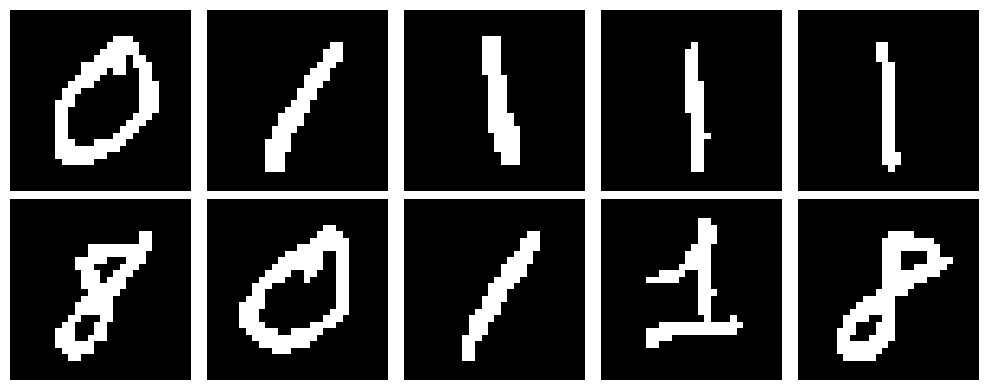

In [5]:
# plot 10 datapoints 
plot_mnist_components(X[:10,:])

In [6]:
# E step
def E_step(pi, mu, x, eps=1e-6):
    N, D = x.shape
    K = pi.shape[0]

    gamma_log = np.zeros((N, K), dtype=np.float64)

    for n in range(N):
        for k in range(K):
            gamma_log[n, k] = np.log(pi[k] + eps)
            for d in range(D):
                mu_kd = np.clip(mu[k, d], eps, 1 - eps)
                gamma_log[n, k] += x[n, d] * np.log(mu_kd) + (1 - x[n, d]) * np.log(1 - mu_kd)

    # normalise in a stable way
    gamma = np.empty_like(gamma_log)
    for n in range(N):
        m = np.max(gamma_log[n, :])
        row = np.exp(gamma_log[n, :] - m)
        gamma[n, :] = row / row.sum()

    return gamma

# M step
def M_step(gamma, x):
    N, D = x.shape
    N_eff = gamma.sum(axis=0)              # (K,)
    mu = (gamma.T @ x) / N_eff[:, None]    # (K, D)
    pi = N_eff / N
    return pi, mu
    

In [7]:
#training hyperparameters
N = 600
K = 3
EM_iterations = 10

#subset of data
x = X[:N,:]

# initialisation of parameters
D = x.shape[1] # dimension of the data
gamma = np.ones((N, K)) / K
pi = np.ones(K) * 1/K
mu = np.random.uniform(0.25, 0.75, size=(K, D))
eps = 1e-6

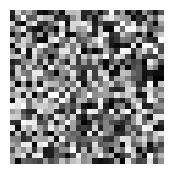

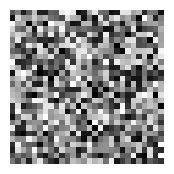

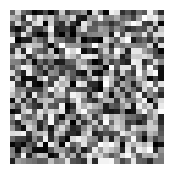

In [8]:
for i in range(K):
    plot_mnist_vector(mu[i,:])

In [9]:
print(f'<<<Training the mixture model with EM for {EM_iterations} iterations>>>\n')
loss_list = np.ones(EM_iterations)

for i in range (EM_iterations):
    gamma = E_step(pi, mu, x)
    pi, mu =  M_step(gamma, x)
    loss = bernoulli_mixture_nll(pi, mu, x)

    loss_list[i] = loss
    print(f'Iteration {i} terminated with loss: {loss}')



<<<Training the mixture model with EM for 10 iterations>>>

Iteration 0 terminated with loss: 105351.41721876491
Iteration 1 terminated with loss: 97333.1977646977
Iteration 2 terminated with loss: 95200.93471078547
Iteration 3 terminated with loss: 94540.31245355091
Iteration 4 terminated with loss: 94291.01963923773
Iteration 5 terminated with loss: 94095.97952367156
Iteration 6 terminated with loss: 94006.90083941717
Iteration 7 terminated with loss: 93977.55422657884
Iteration 8 terminated with loss: 93949.03150369745
Iteration 9 terminated with loss: 93918.9494202492


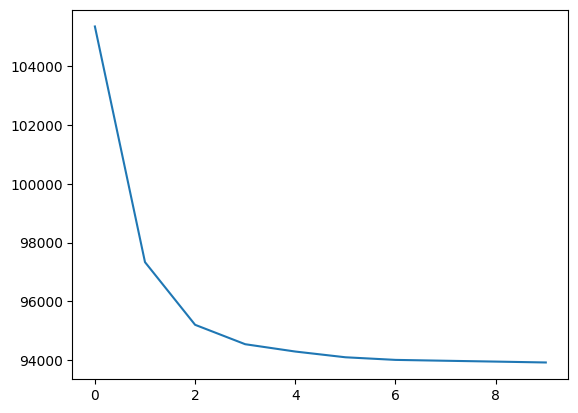

In [10]:
N_list = np.array(range(EM_iterations))
plt.figure()
plt.plot(N_list, loss_list)

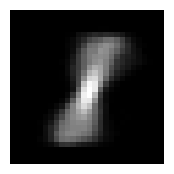

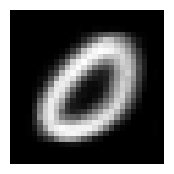

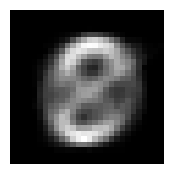

In [11]:
# plot the means of the Bernoulli mixtures. 
for i in range(K):
    plot_mnist_vector(mu[i,:])

In [12]:
# training with different iterations
print(f'<<< Training the mixture model with EM for {EM_iterations} iterations >>>\n')

K_list = [3, 6, 9]

all_loss = {}


for K in K_list:

    print(f"\n===== Training with K = {K} =====")


    N, D = x.shape

    rng = np.random.default_rng(0)

    pi = rng.dirichlet(np.ones(K))
    mu = rng.uniform(1e-3, 1-1e-3, size=(K, D))


    loss_list = np.zeros(EM_iterations)


    for i in range(EM_iterations):

        gamma = E_step(pi, mu, x)
        pi, mu = M_step(gamma, x)

        loss = bernoulli_mixture_nll(pi, mu, x)

        loss_list[i] = loss

        print(f'K={K} | Iter {i:03d} | NLL = {loss:.6f}')


    all_loss[K] = loss_list



<<< Training the mixture model with EM for 10 iterations >>>


===== Training with K = 3 =====
K=3 | Iter 000 | NLL = 104365.730411
K=3 | Iter 001 | NLL = 99544.505630
K=3 | Iter 002 | NLL = 98495.653314
K=3 | Iter 003 | NLL = 98309.379101
K=3 | Iter 004 | NLL = 98271.698141
K=3 | Iter 005 | NLL = 98268.691509
K=3 | Iter 006 | NLL = 98264.442889
K=3 | Iter 007 | NLL = 98261.913005
K=3 | Iter 008 | NLL = 98260.553832
K=3 | Iter 009 | NLL = 98260.538970

===== Training with K = 6 =====
K=6 | Iter 000 | NLL = 98942.409263
K=6 | Iter 001 | NLL = 90964.342051
K=6 | Iter 002 | NLL = 88371.292098
K=6 | Iter 003 | NLL = 87192.730289
K=6 | Iter 004 | NLL = 86634.558962
K=6 | Iter 005 | NLL = 86329.565934
K=6 | Iter 006 | NLL = 86082.742282
K=6 | Iter 007 | NLL = 85928.338762
K=6 | Iter 008 | NLL = 85693.098214
K=6 | Iter 009 | NLL = 85331.331638

===== Training with K = 9 =====
K=9 | Iter 000 | NLL = 97002.825637
K=9 | Iter 001 | NLL = 86728.036910
K=9 | Iter 002 | NLL = 83498.671302
K=9 | Iter

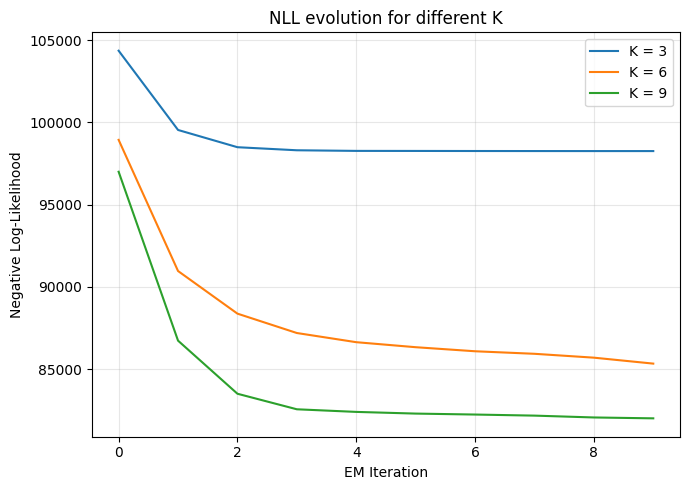

In [33]:
plt.figure(figsize=(7, 5))

for K in K_list:
    plt.plot(
        np.arange(EM_iterations),
        all_loss[K],
        label=f"K = {K}"
    )

plt.xlabel("EM Iteration")
plt.ylabel("Negative Log-Likelihood")
plt.title("NLL evolution for different K")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./loss_k')
plt.show()

In [15]:
print(f'<<< Training with different random seeds >>>\n')

K = 3
seed_list = [0, 1, 2, 3]
EM_iterations = 10

all_loss_seed = {}


for seed in seed_list:

    print(f"\n===== K = {K}, seed = {seed} =====")

    rng = np.random.default_rng(seed)

    N, D = x.shape

    pi = rng.dirichlet(np.ones(K))
    mu = rng.uniform(1e-3, 1-1e-3, size=(K, D))

    loss_list = np.zeros(EM_iterations)


    for i in range(EM_iterations):

        gamma = E_step(pi, mu, x)
        pi, mu = M_step(gamma, x)

        loss = bernoulli_mixture_nll(pi, mu, x)

        loss_list[i] = loss

        print(f'seed={seed} | Iter {i:03d} | NLL={loss:.6f}')


    all_loss_seed[seed] = loss_list



<<< Training with different random seeds >>>


===== K = 3, seed = 0 =====
seed=0 | Iter 000 | NLL=104365.730411
seed=0 | Iter 001 | NLL=99544.505630
seed=0 | Iter 002 | NLL=98495.653314
seed=0 | Iter 003 | NLL=98309.379101
seed=0 | Iter 004 | NLL=98271.698141
seed=0 | Iter 005 | NLL=98268.691509
seed=0 | Iter 006 | NLL=98264.442889
seed=0 | Iter 007 | NLL=98261.913005
seed=0 | Iter 008 | NLL=98260.553832
seed=0 | Iter 009 | NLL=98260.538970

===== K = 3, seed = 1 =====
seed=1 | Iter 000 | NLL=110791.349698
seed=1 | Iter 001 | NLL=97962.686284
seed=1 | Iter 002 | NLL=94649.209602
seed=1 | Iter 003 | NLL=93728.604626
seed=1 | Iter 004 | NLL=93164.644915
seed=1 | Iter 005 | NLL=92686.088829
seed=1 | Iter 006 | NLL=92104.417680
seed=1 | Iter 007 | NLL=91828.639776
seed=1 | Iter 008 | NLL=91675.330051
seed=1 | Iter 009 | NLL=91553.151031

===== K = 3, seed = 2 =====
seed=2 | Iter 000 | NLL=107937.648987
seed=2 | Iter 001 | NLL=98097.911889
seed=2 | Iter 002 | NLL=96810.496923
seed=2 | Iter

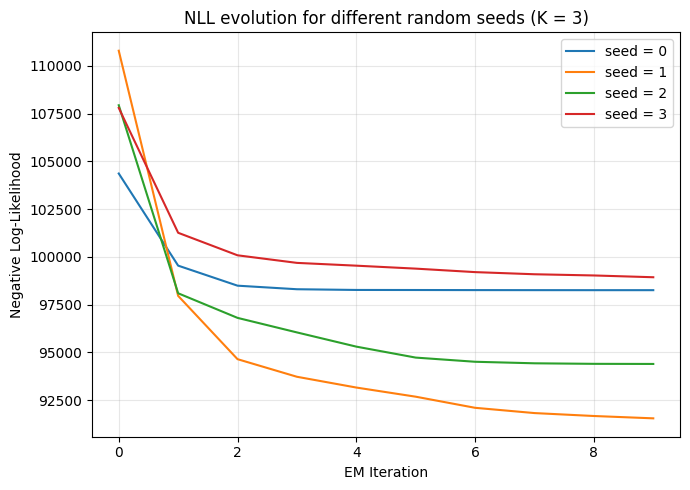

In [16]:
plt.figure(figsize=(7, 5))

for seed in seed_list:

    plt.plot(
        np.arange(EM_iterations),
        all_loss_seed[seed],
        label=f"seed = {seed}"
    )

plt.xlabel("EM Iteration")
plt.ylabel("Negative Log-Likelihood")
plt.title(f"NLL evolution for different random seeds (K = {K})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./loss_seed')
plt.show()

In [17]:
#Task 6
def sample_bernoulli_mixture(pi, mu, n_samples=10):
    """
    Sample from a Bernoulli mixture model.
    """
    ### TO BE IMPLEMENTED (Tasks 6 and 7)
    idx = np.random.choice(len(pi), size = n_samples, p=pi)
    x_new = np.ones(shape=(n_samples, mu.shape[1]))

    for i in range(n_samples):
        K = idx[i]
        p = mu[K, :]
        x_new[i, :] = np.random.binomial(1, p)


    return x_new


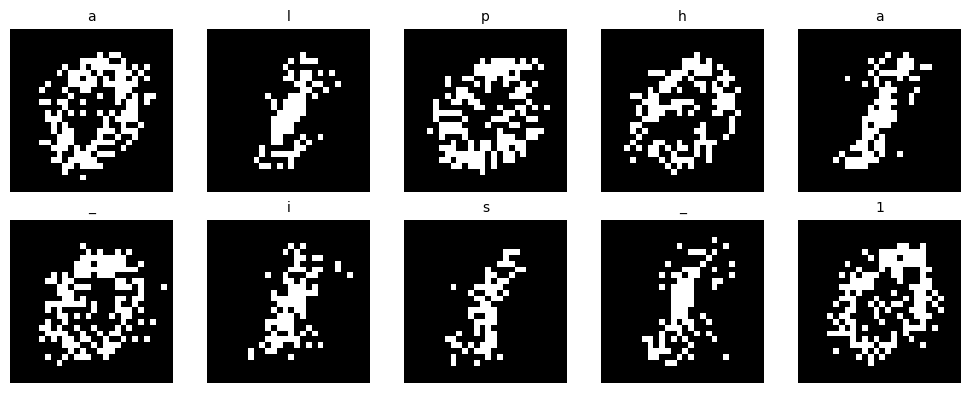

In [43]:
x_new = sample_bernoulli_mixture(pi, mu, n_samples=10)
plot_mnist_components(x_new, titles = "alpha_is_1")

In [44]:
#Task 7
def temp(mu, alpha):
    return mu ** alpha / (mu ** alpha + (1- mu) ** alpha)

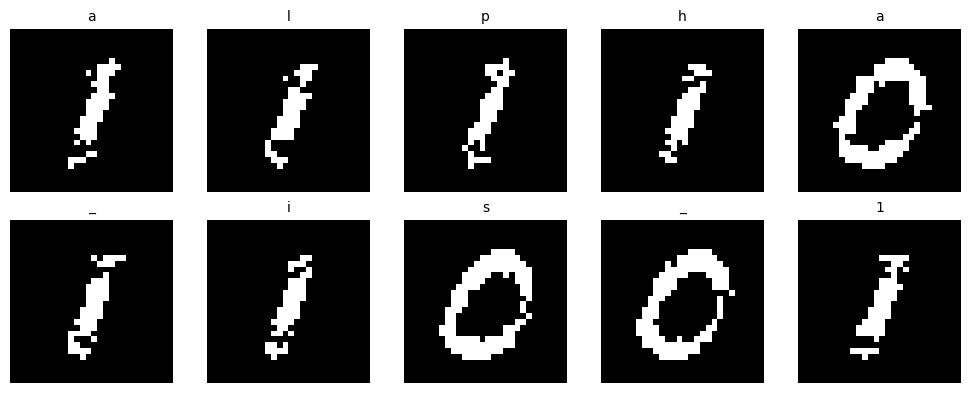

In [45]:
x_new_alpha_1 = sample_bernoulli_mixture(pi, temp(mu, 10), n_samples=10)
plot_mnist_components(x_new_alpha_1, titles = "alpha_is_10")

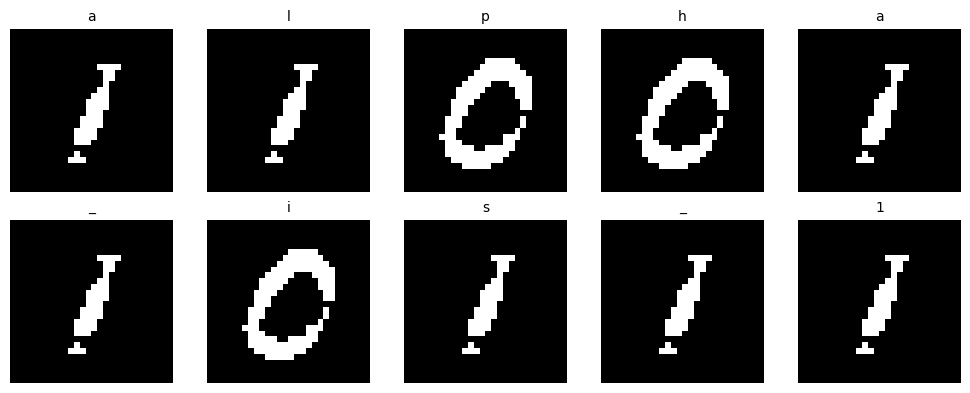

In [46]:
x_new_alpha_2 = sample_bernoulli_mixture(pi, temp(mu, 1000), n_samples=10)
plot_mnist_components(x_new_alpha_2, titles = "alpha_is_100")